Quick introduction to look for how to look at the data and what the first task will require. 

SDSS J114404.76+052951.77 is a white dwarf. https://ui.adsabs.harvard.edu/abs/2015ApJ...810L..17G/abstract suggested that it had a gas disc around it due to emission from Calcium. We found that the emission is actually due to an orbiting companion, probably a brown dwarf. Your task is to measure the orbital period of the system.  

Some reading material on similar systems here https://ui.adsabs.harvard.edu/public-libraries/qIO0Ze9fQzGnpI49Ywtv4A.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
import natsort


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

#fitting the emission lines
from astropy.modeling import models, fitting
from astropy import constants as const
from astropy import units as u
import pandas as pd
from astropy.convolution import convolve, Box1DKernel
from scipy.signal import find_peaks
from astropy.table import Table
from astropy.io import fits
import matplotlib.cm as cm

Iterating through all of the data.

In [4]:
path = "/Users/linaflorez/Desktop/UT_TAURUS/WDJ114404.76+052951.77/" #note the / on the end
print(os.listdir(path))
vispath = path + 'VIS_notell/'
sp_csv = natsort.natsorted(glob.glob(vispath+'*TAC.csv')) #makes an array containing the path to all csv files. Note the TAC as I didn't want to include the merged spectrum
sp_fits = natsort.natsorted(glob.glob(vispath+'*TAC.fits')) #makes an array containing the path to all csv files. Note the TAC as I didn't want to include the merged spectrum

['UVB', 'VIS_notell', '.DS_Store', 'VIS', 'NIR']


['UVB', 'VIS_notell', '.DS_Store', 'VIS', 'NIR']


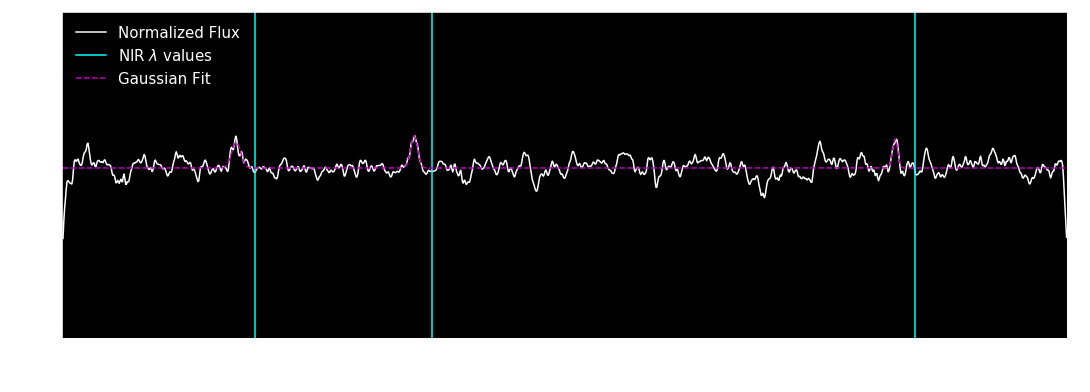

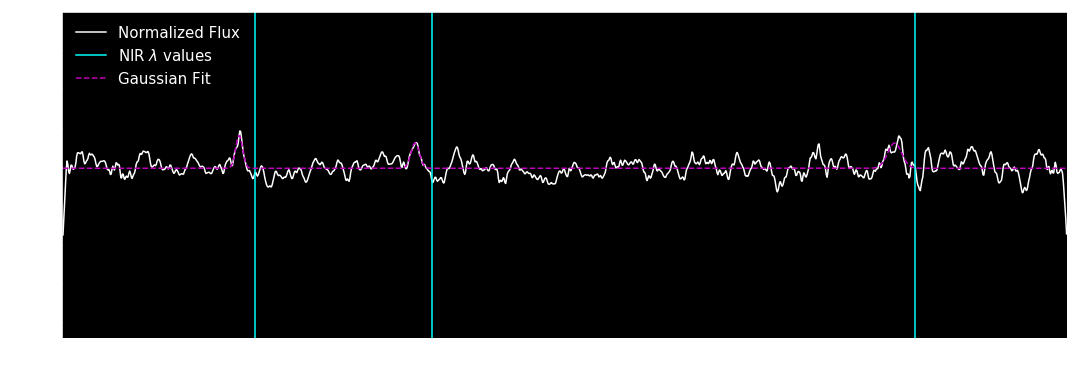

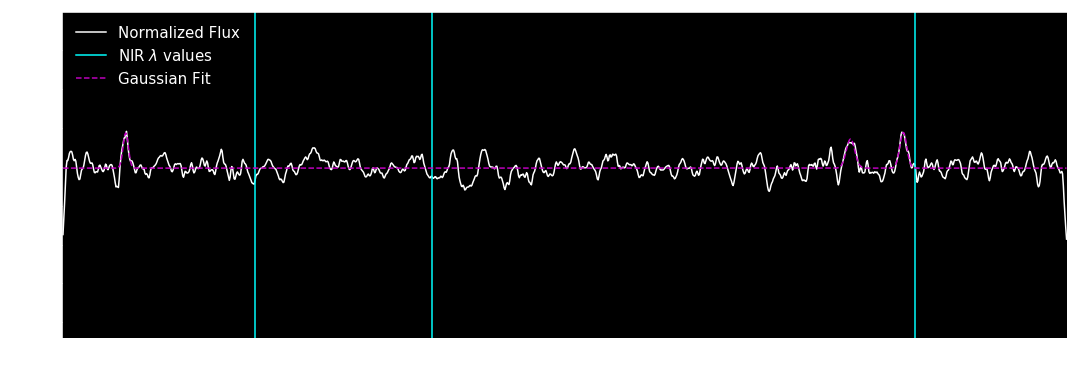

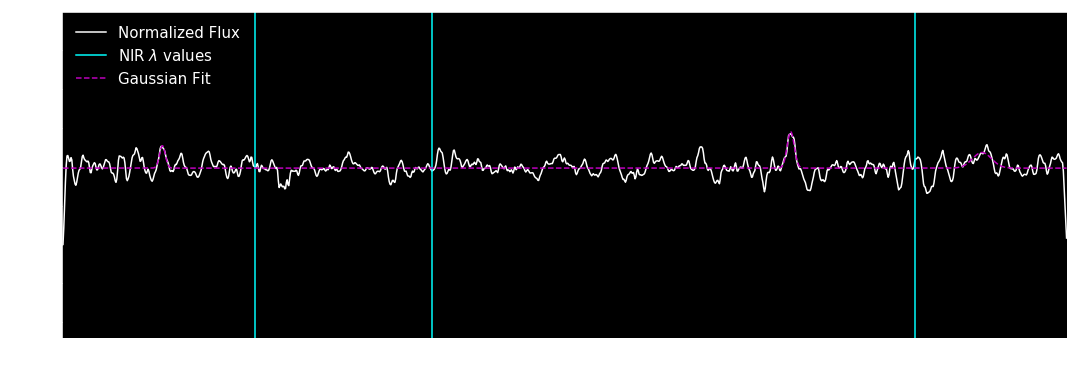

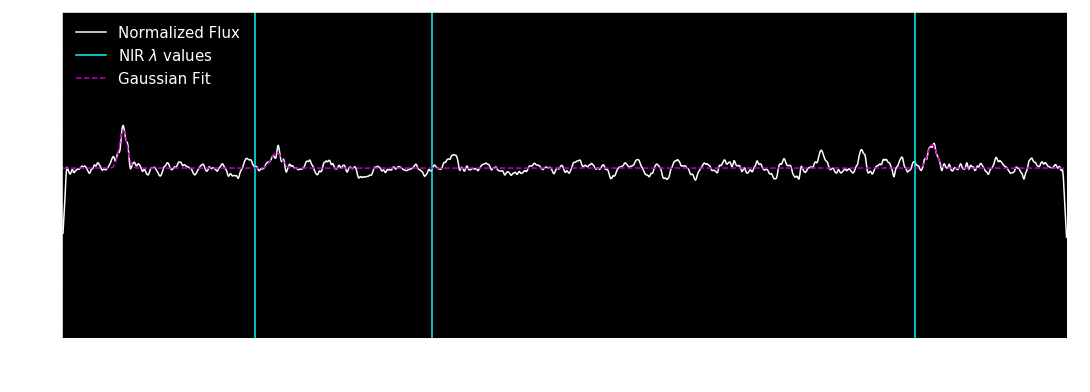

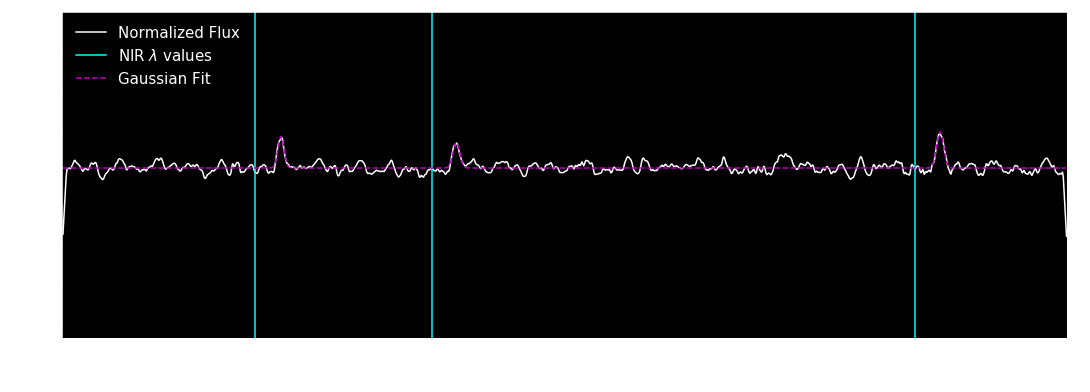

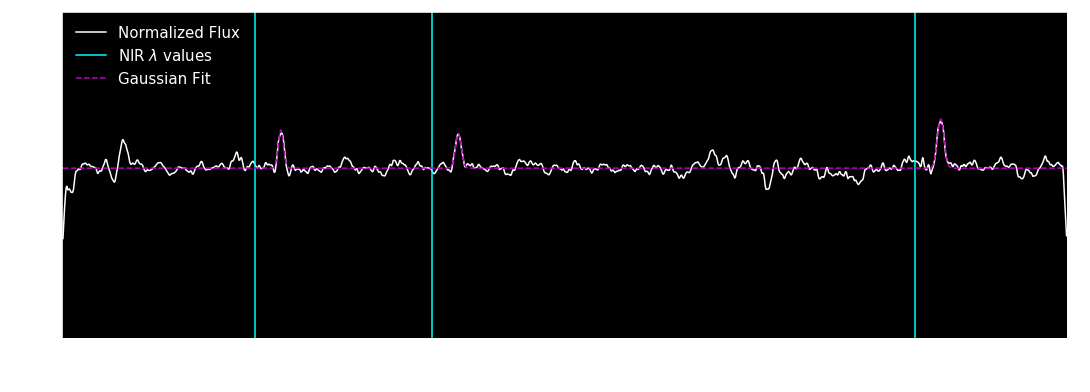

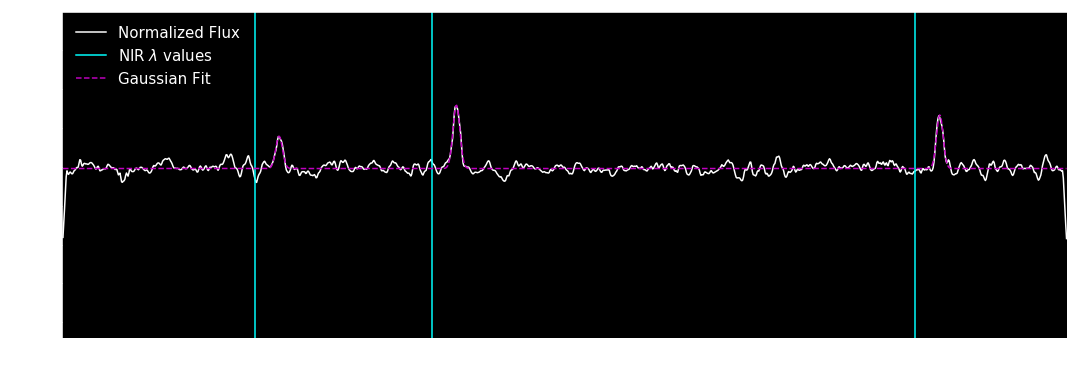

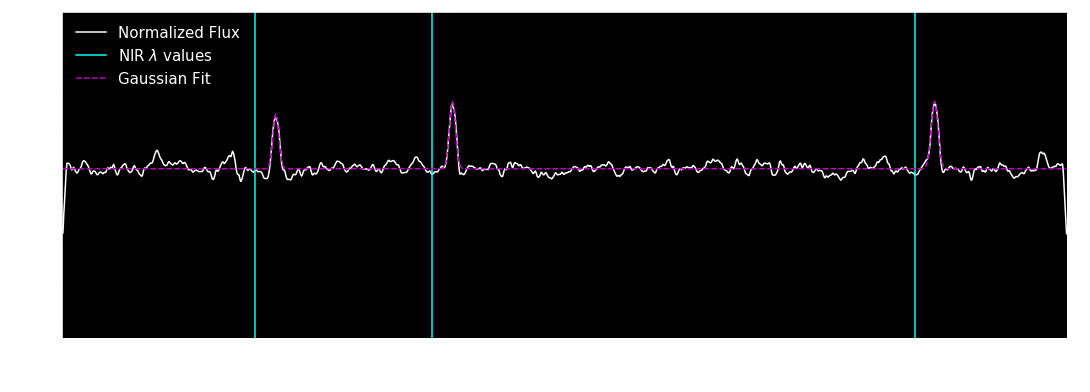

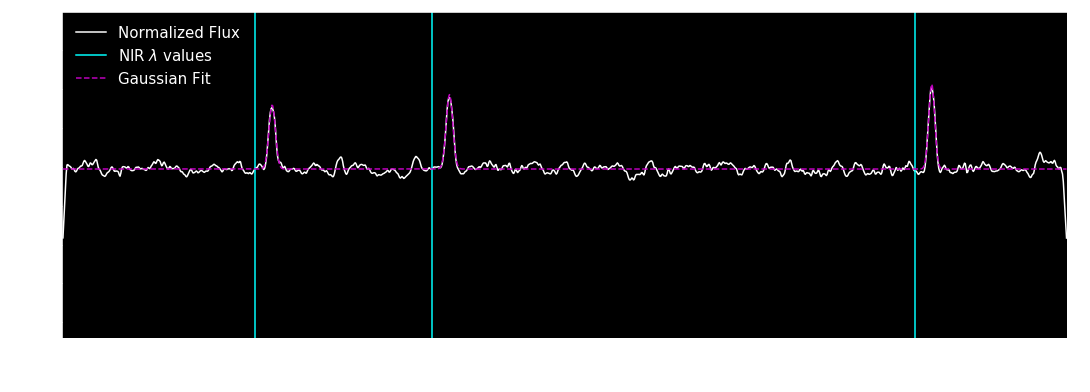

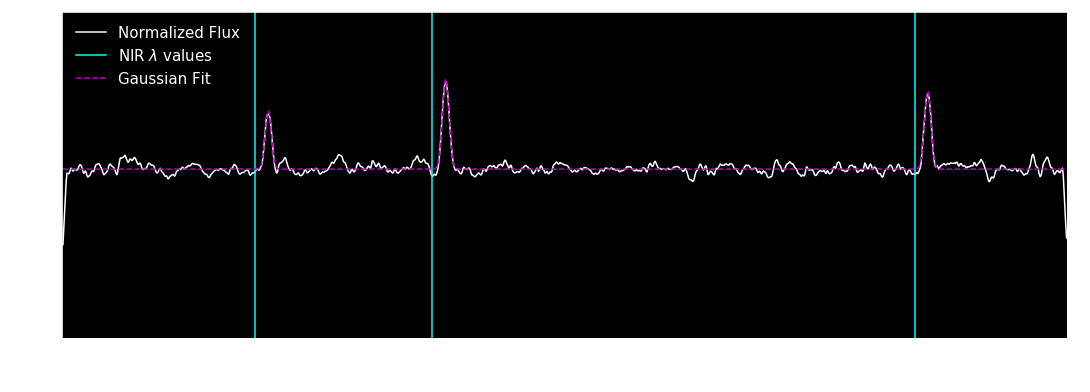

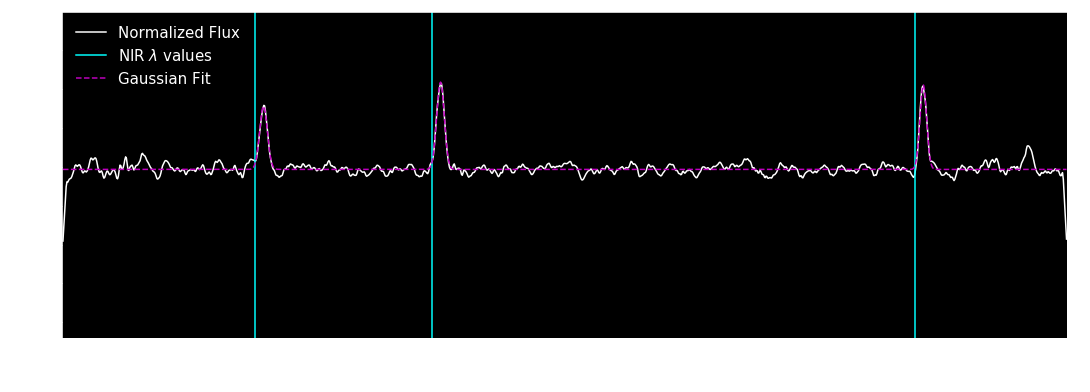

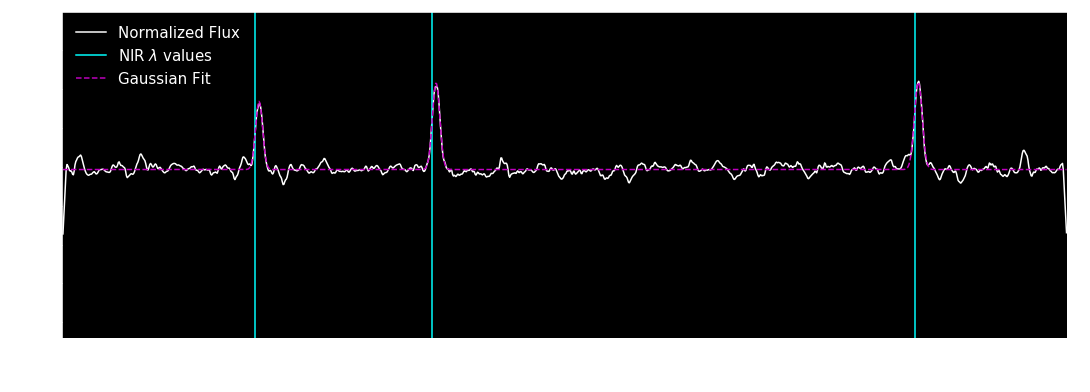

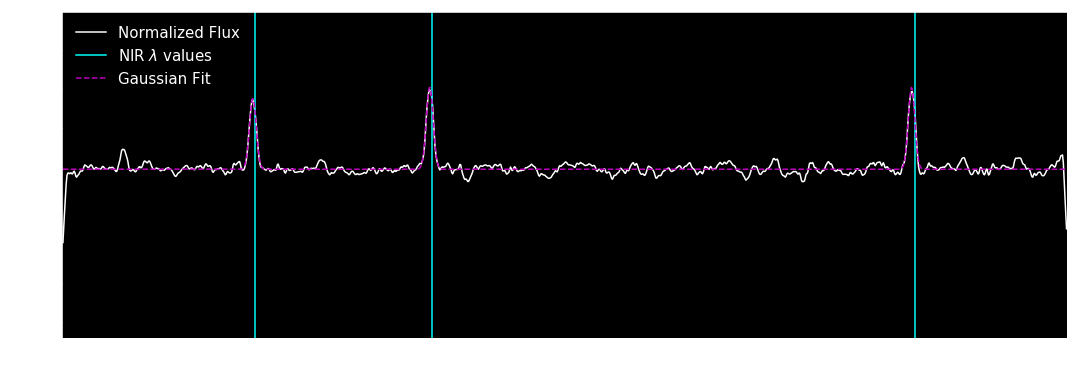

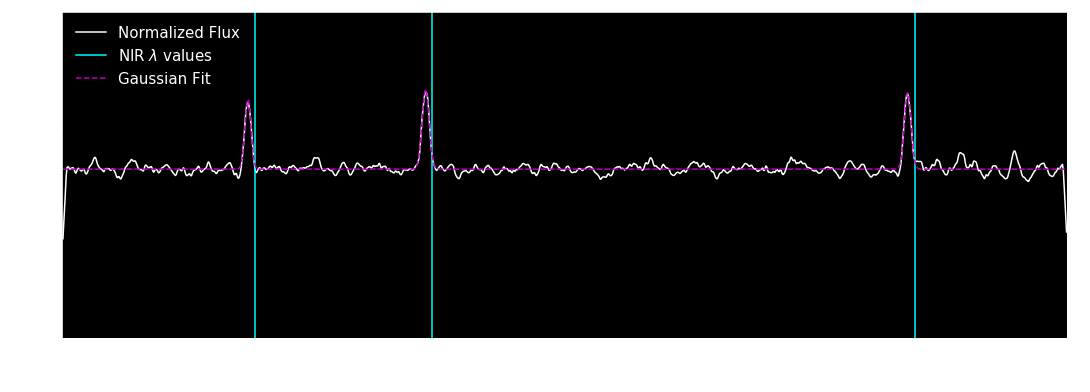

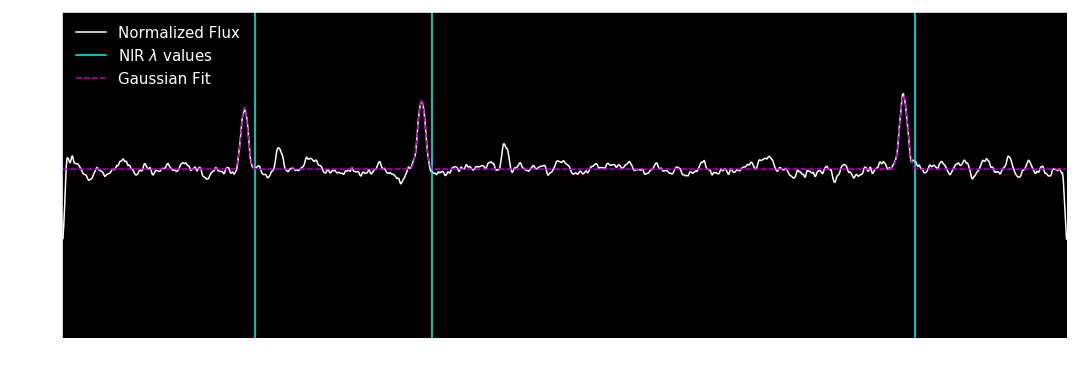

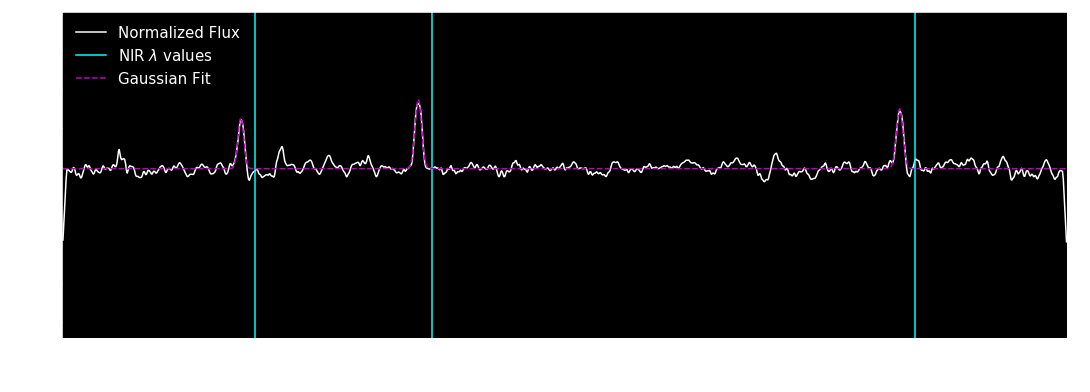

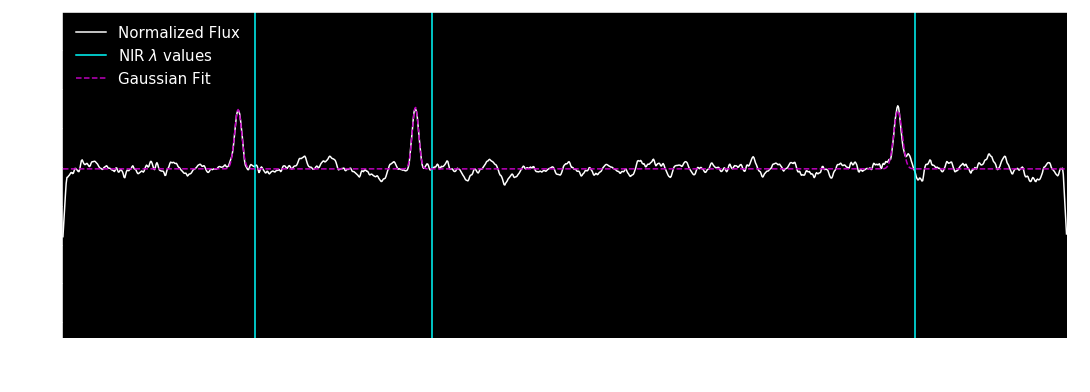

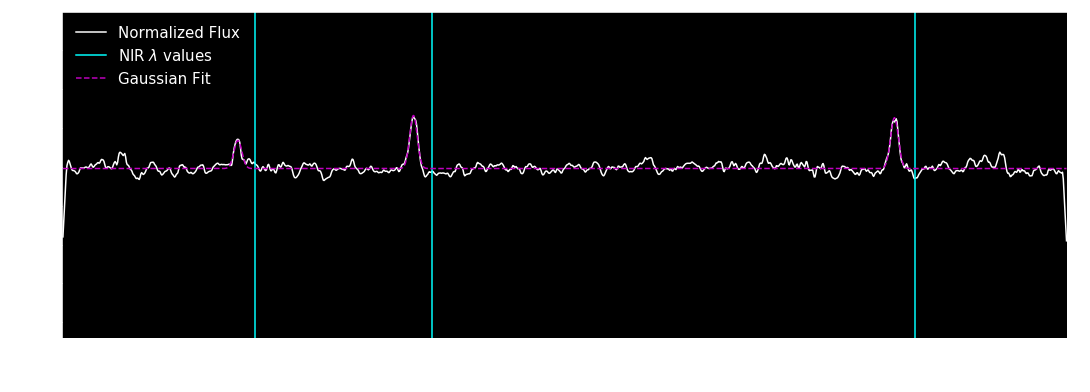

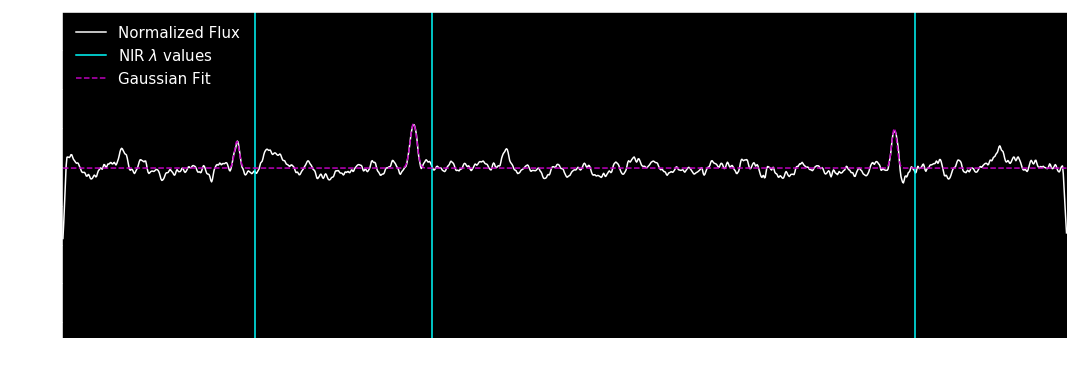

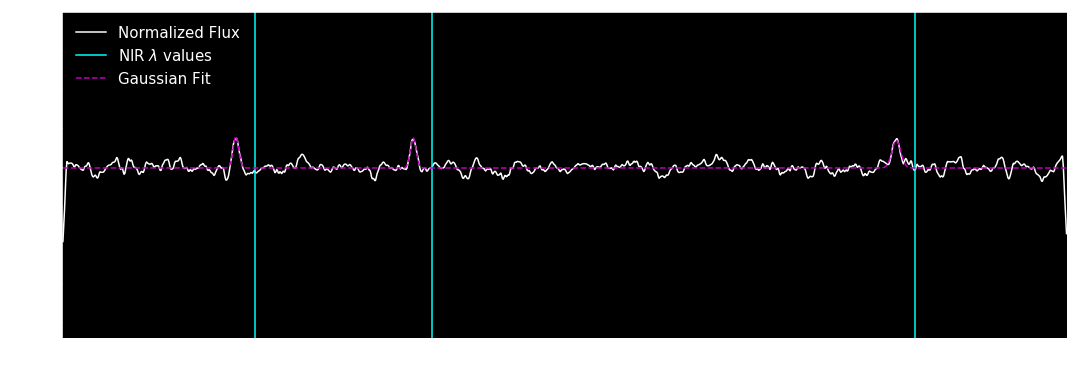

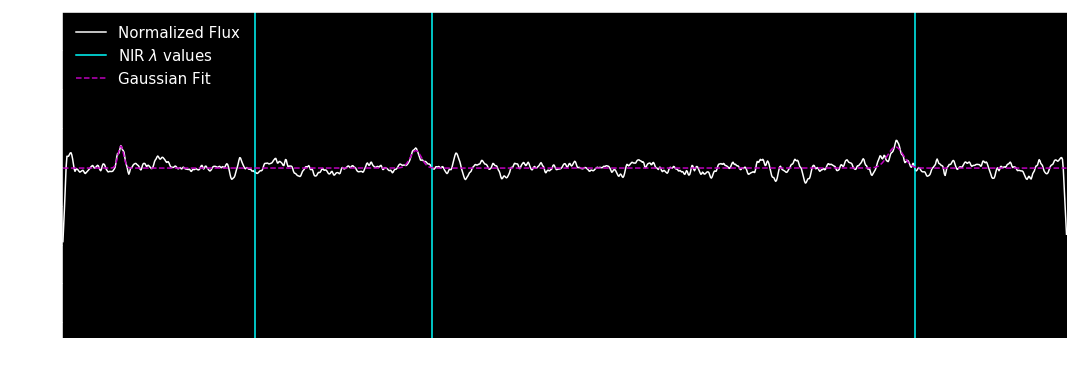

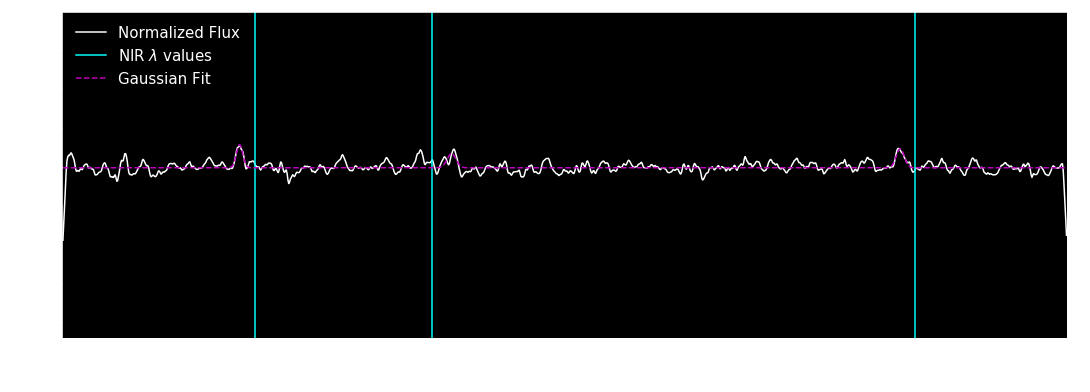

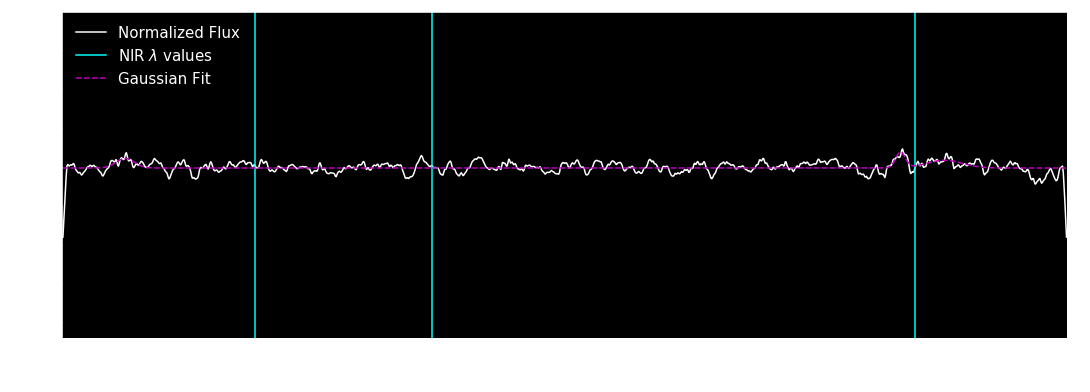

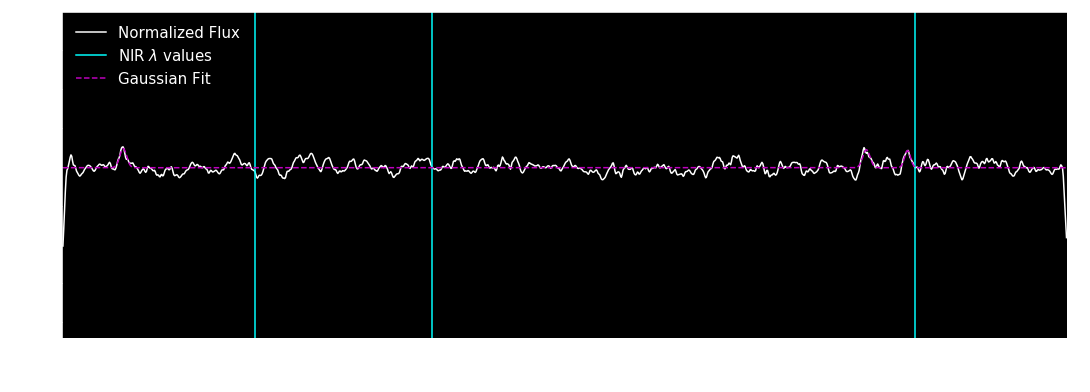

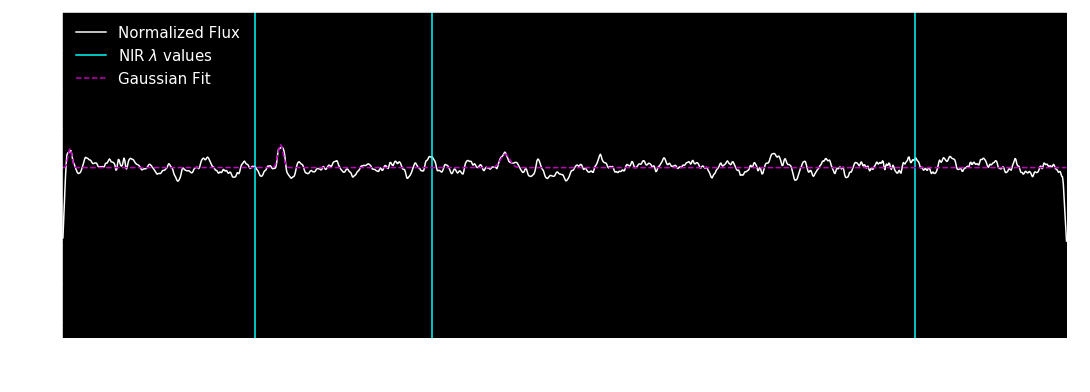

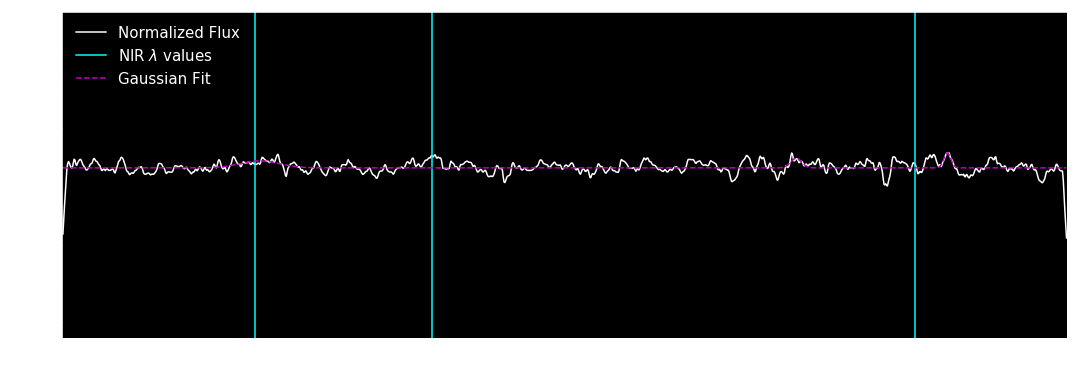

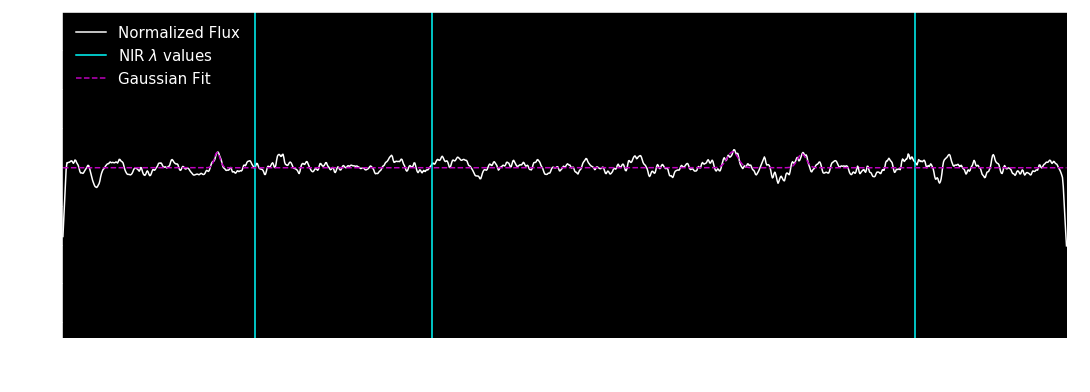

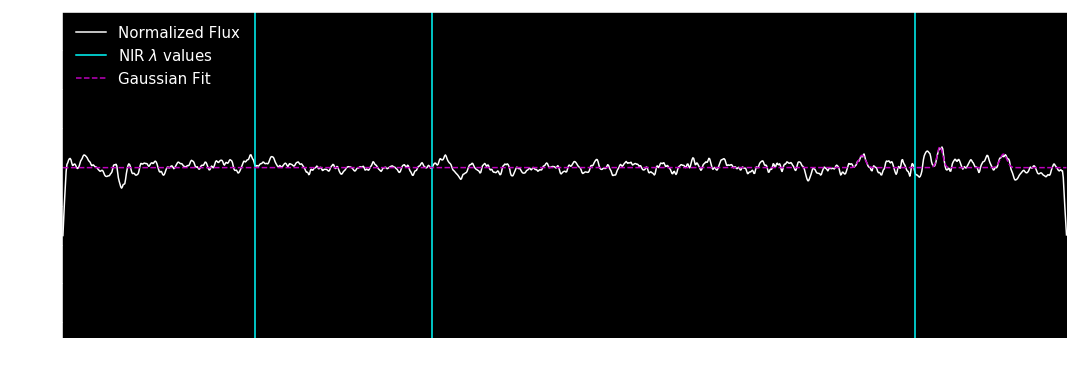

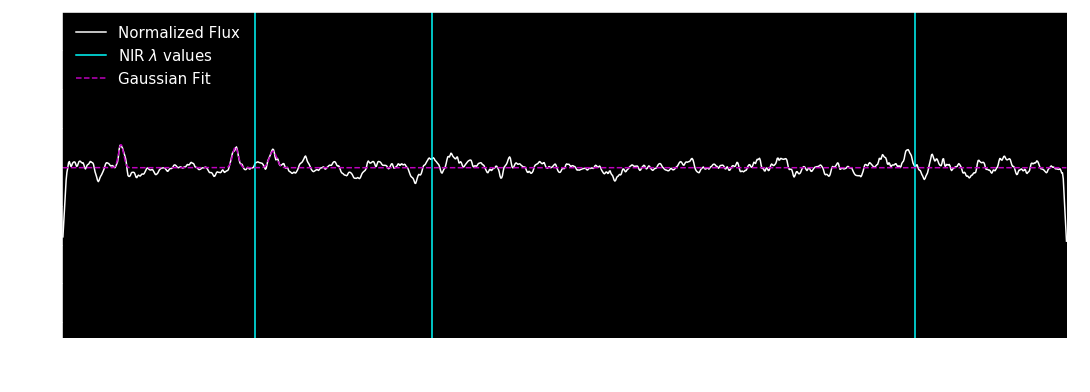

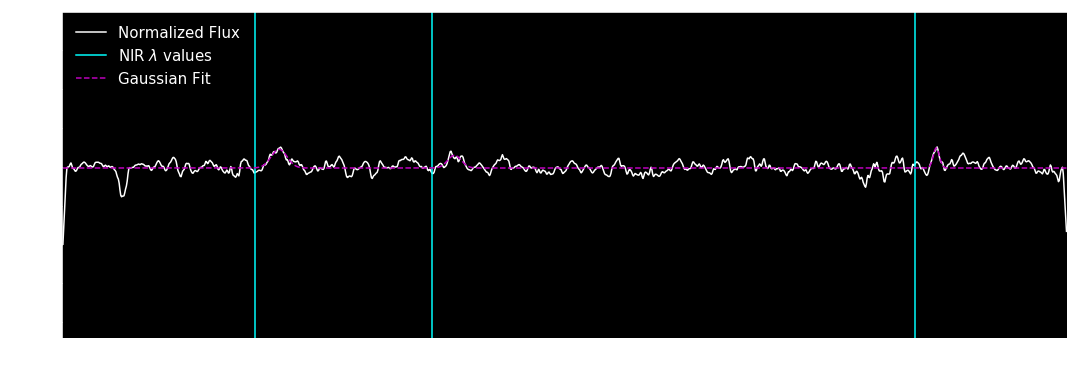

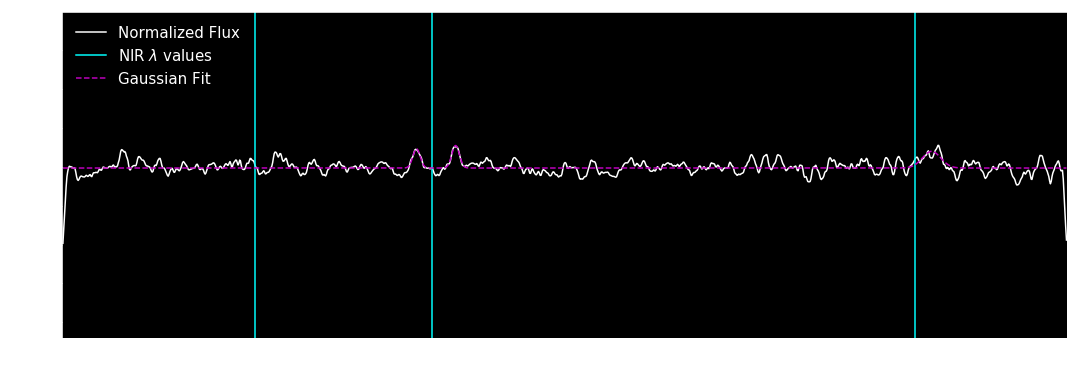

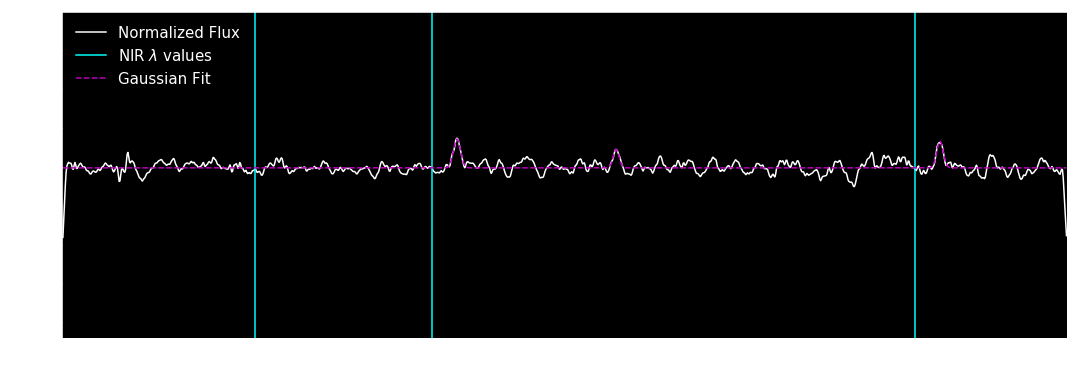

In [17]:
#%%capture
path = "/Users/linaflorez/Desktop/UT_TAURUS/WDJ114404.76+052951.77/" #note the / on the end
print(os.listdir(path))
vispath = path + 'VIS_notell/'
sp_csv = natsort.natsorted(glob.glob(vispath+'*TAC.csv')) #makes an array containing the path to all csv files. Note the TAC as I didn't want to include the merged spectrum
sp_fits = natsort.natsorted(glob.glob(vispath+'*TAC.fits')) #makes an array containing the path to all csv files. Note the TAC as I didn't want to include the merged spectrum
peak_wavelength_range = [(8494,8498),(8538,8542.5),(8657.75,8662.5)]
wavelength_range = (8450,8700)
NIR_wavelengths = [8498.02, 8542.09, 8662.14]
num_peaks = 3

def fitting_emission_lines(w,f,num_peaks,wavelength_range, file_num):
    
    ################################################################
    #### MASKING WAVELENGTH & FLUX TO ONLY 
    #### INCLUDE THE PLOTTED SECTION FROM ABOVE
    ################################################################
    overall_min_range, overall_max_range = wavelength_range[0], wavelength_range[1]
    general_mask = (w > overall_min_range) & (w < overall_max_range)
    w, f = w[general_mask], f[general_mask]
    
    
    ################################################################
    #### FITTING THE CONTINUUM USING ASTROPY, FOLLOWED BY 
    #### NORMALIZING & SMOOTHING OUT THE FLUX ACCORDINGLY
    ################################################################
    fitter = fitting.LinearLSQFitter()
    n_init = models.Polynomial1D(1)
    n_fit = fitter(n_init, w, f)
    f = f / n_fit(w)
    f = convolve(f, Box1DKernel(10))
    
    
    ################################################################
    #### FINDING THE PEAKS USING SCIPY
    ################################################################
    peaks, properties = find_peaks(f, height = 0.25, distance = 40)
    w_peaks = w[peaks][(np.argpartition(f[peaks], -3)[-3:])]
    f_peaks = f[peaks][(np.argpartition(f[peaks], -3)[-3:])]


    w_sorted = np.sort(w_peaks)
    detection_test = np.zeros(num_peaks)
    for i in range(num_peaks):
        detection_test[i] = NIR_wavelengths[i] - w_sorted[i]

    sign = np.sign(detection_test)
    if ((all(elements == 1 for elements in sign)) or (all(elements == -1 for elements in sign))) and ((all(abs(values) <= 30 for values in detection_test))):
        detection = "Yes" 
    else:
        detection = "No" 

        
    ################################################################
    #### FITTING THE PEAKS USING ASTROPY
    ################################################################
    for i in range(num_peaks):
        if i == 0:
            model = models.Const1D(1.0)+models.Gaussian1D(1.0, w_peaks[i], 1)
        else:   
            model = model + models.Gaussian1D(1.0, w_peaks[i], 1)
        
    ################################################################
    #### MAKING THE FITS
    ################################################################
    #gg_init = models.Const1D(1.0)
    #g_init = gg_init + model
    fitter = fitting.LevMarLSQFitter()
    g_peak_norm = fitter(model, w, f) 
    fit_e = fitter.fit_info["param_cov"]

    ################################################################
    #### PLOTTING NORMALIZED DATA
    ################################################################
    # Plot the data with the best-fit model
    plt.style.use("dark_background")
    plt.figure(num=None, figsize=(18, 6),facecolor='w', edgecolor='k')
    plt.plot(w, f, "w", markersize = 10, label = "Normalized Flux")
    
    
    ################################################################
    #### PLOTTING FITS DATA
    ################################################################
    plt.axvline(NIR_wavelengths[0], color = "cyan", label = "NIR ${\lambda}$ values")
    plt.axvline(NIR_wavelengths[1], color = "cyan")
    plt.axvline(NIR_wavelengths[2], color = "cyan")
#     plt.plot(w[peaks],f[peaks],"bo", label = "scipy (each peak)")
    plt.plot(w, g_peak_norm(w),"m--", label = "Gaussian Fit")
#     plt.plot(w, n_fit(w)+1, "m.", label = "Continuum Fit")
    plt.xlabel("Wavelength (${\AA}$)", weight = "bold", size = 15)
    plt.ylabel("Flux", weight = "bold", size = 15)
    plt.legend(loc = "best", prop = {"size" : 15}, frameon = False)
    plt.tick_params(axis= "both", which = "major", labelsize = 13)
    plt.xlim(overall_min_range, overall_max_range)
    plt.xlim(wavelength_range[0],wavelength_range[1])
    plt.ylim(-0.1,2)
    plt.savefig("/Users/linaflorez/Desktop/UT_TAURUS/Plots/BLAH/%i.pdf" % (file_num), transparent = True, dpi = 300, quality = 95)
    plt.show()
    return g_peak_norm, detection


def doppler_velocity_func(NIR_wavelengths,csv_path_files, fits_path_files, num_peaks,wavelength_range):
    ################################################################
    #### CONVERTING C TO KM/S
    ################################################################
    c = ((const.c).to(u.km/u.s)).value
    
    
    ###############################################################
    #### ITERATING THROUGH ALL THE CSV FILES
    ################################################################
    sp = csv_path_files
    sp_f = fits_path_files
    
    
    ###############################################################
    #### STORING THE VELOCITIES
    ################################################################    
    tracking_file_num = []
    vel1 = []
    vel2 = []
    vel3 = []
    file_path = []
    MJD = []
    detections = []
    
    
    for i in range(0,np.shape(sp)[0]):
        ###############################################################
        #### GRABBING INFO FROM CSV FILES
        ################################################################ 
        s = sp[i]
        file_path.append(s.split("VIS_notell/",1)[1])
        w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
        peak_values, detection = fitting_emission_lines(w,f,num_peaks, wavelength_range,i)

        ###############################################################
        #### GRABBING INFO FROM FITS FILES
        ################################################################ 
        s_fits = sp_f[i]
        hdulist = fits.open(s_fits)
        hdu = hdulist[0]
        MJD_OBS = hdu.header["MJD-OBS"] #in mjd (units are days)
        EXPTIME = hdu.header["EXPTIME"] # in secs
        time_dependence = (MJD_OBS * u.d) + (((EXPTIME/2)*u.s).to(u.d))
        time_dependence = time_dependence.value
        
        ###############################################################
        #### VALUES FROM THE NIR WEBSITE
        ################################################################
        NIR_wavelength_peak1 = NIR_wavelengths[0]
        NIR_wavelength_peak2 = NIR_wavelengths[1]
        NIR_wavelength_peak3 = NIR_wavelengths[2]
        
        
        ###############################################################
        #### WAVELENGTHS OF THE PEAKS COURTESY OF THE GAUSSIAN FITS
        ################################################################
        peak_w = [peak_values.mean_1.value, peak_values.mean_2.value, peak_values.mean_3.value]
        peak_w = np.sort(peak_w)
        peak1_fitvalue = peak_w[0]
        peak2_fitvalue = peak_w[1]
        peak3_fitvalue = peak_w[2]
        
        
        ###############################################################
        #### CALCULATING THE SHIFT
        ################################################################
        shift_peak1 = NIR_wavelength_peak1 - peak1_fitvalue
        shift_peak2 = NIR_wavelength_peak2 - peak2_fitvalue
        shift_peak3 = NIR_wavelength_peak3 - peak3_fitvalue
        
        
        ################################################################
        #### EQUATION FOR DOPPLER VELOCITY
        #### SPEED OF LIGHT * (WAVELENGTH SHIFT / OG WAVELENGTH) = VELOCITY
        ################################################################
        d_vel_peak1 = c * (shift_peak1 / NIR_wavelength_peak1)
        d_vel_peak2 = c * (shift_peak2 / NIR_wavelength_peak2)
        d_vel_peak3 = c * (shift_peak3 / NIR_wavelength_peak3)
    

        ###############################################################
        #### STORING VALUES
        ################################################################
        tracking_file_num.append(i)
        vel1.append(d_vel_peak1)
        vel2.append(d_vel_peak2)
        vel3.append(d_vel_peak3)
        MJD.append(time_dependence)
        detections.append(detection)
       
    
    ###############################################################
    #### MAKING DATA TABLE
    ################################################################
    t = Table([tracking_file_num, vel1, vel2,vel3, detections, MJD,file_path], names=("File Number (sp[i])", "First Peak Doppler Velocity (km/s)", \
                                                                       "Second Peak Doppler Velocity (km/s)","Third Peak Doppler Velocity (km/s)",\
                                                                      "Detection", "Time (MJD)","File Path"), meta={"name": "first table"})
    velocities_array = (np.array([vel1,vel2,vel3])).T

            
    return t,tracking_file_num, velocities_array,MJD,detections #doppler_velocities tablein km/s
info_table,file_num,v_array,time_array, detect_array = doppler_velocity_func(NIR_wavelengths,sp_csv,sp_fits,3,wavelength_range)
# info_table.write("DopplerVelocitiesTABLE.csv", format="ascii.csv", overwrite=True)


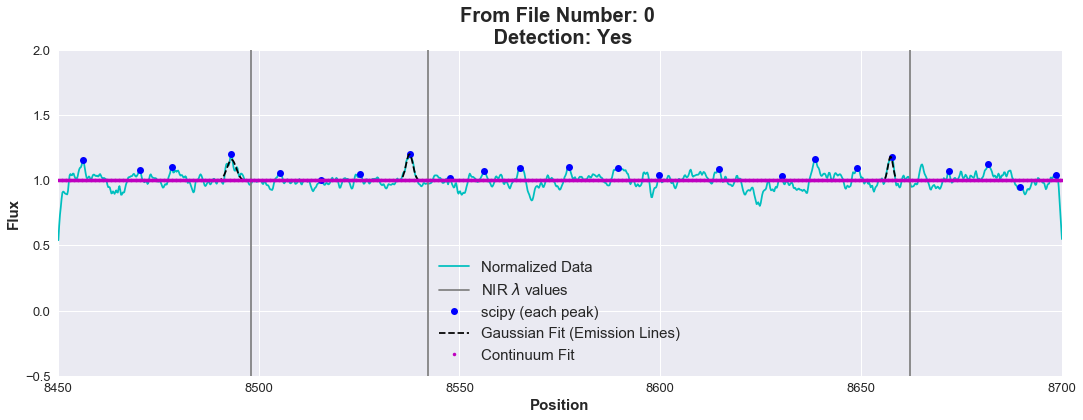

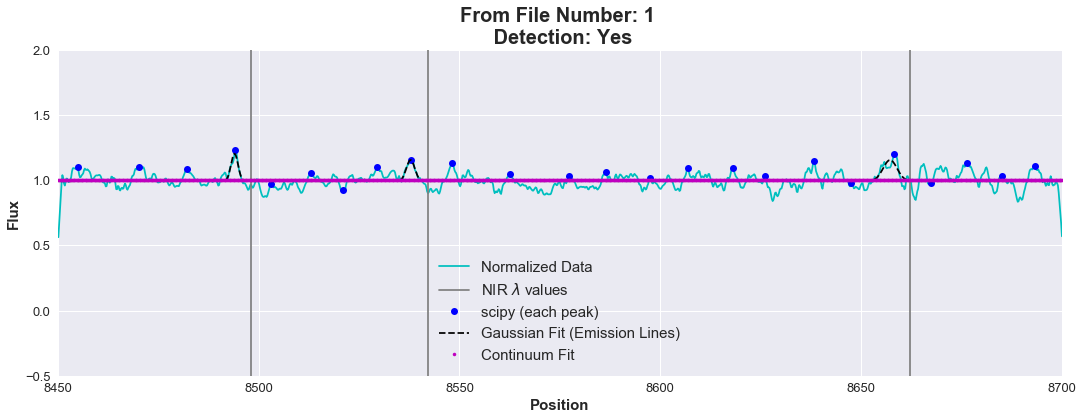

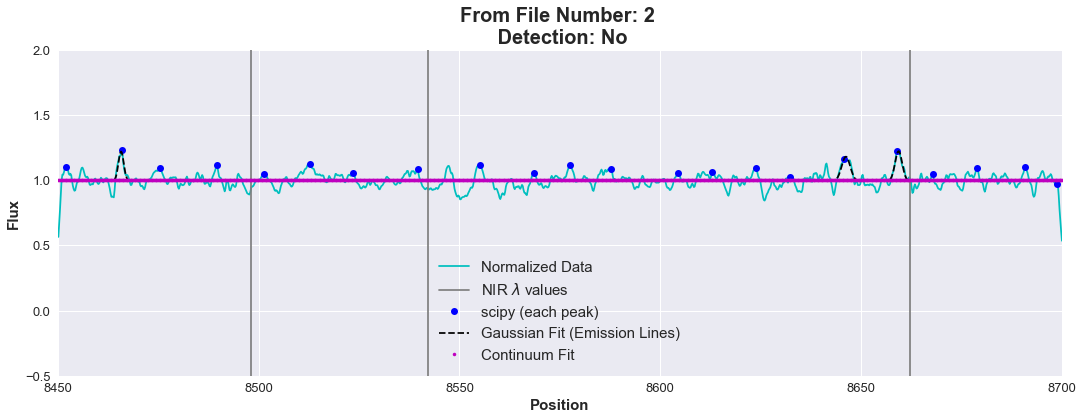

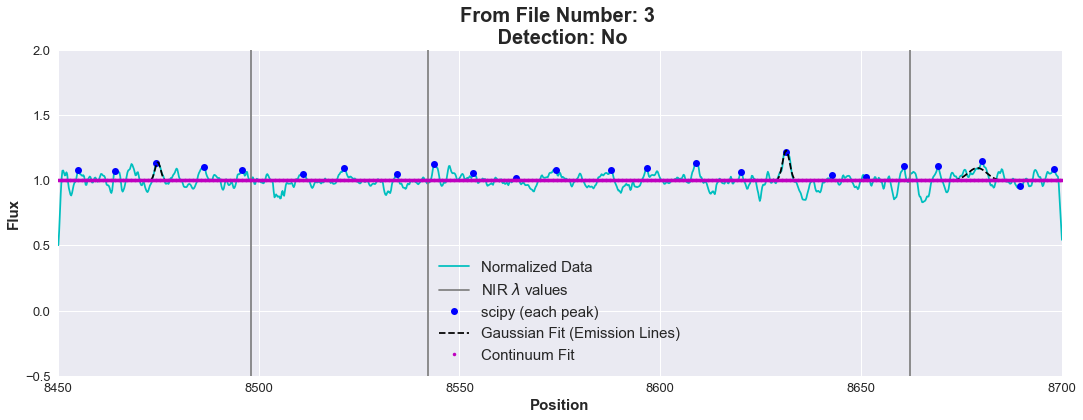

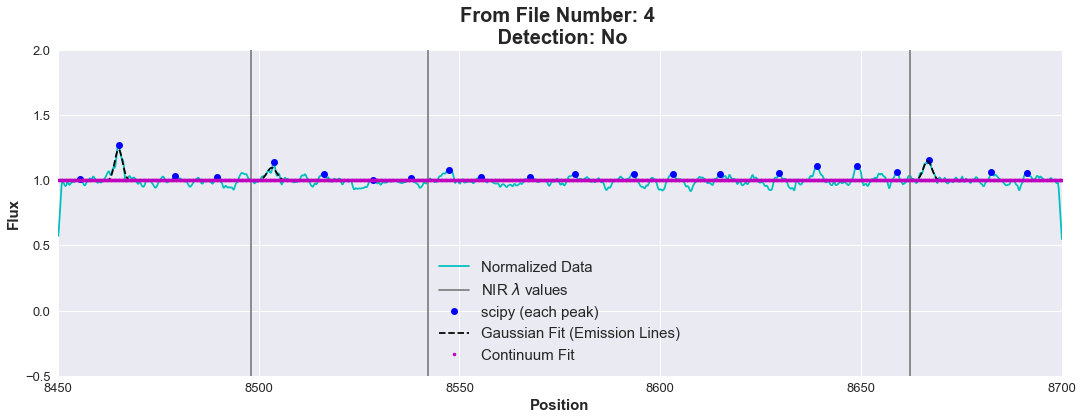

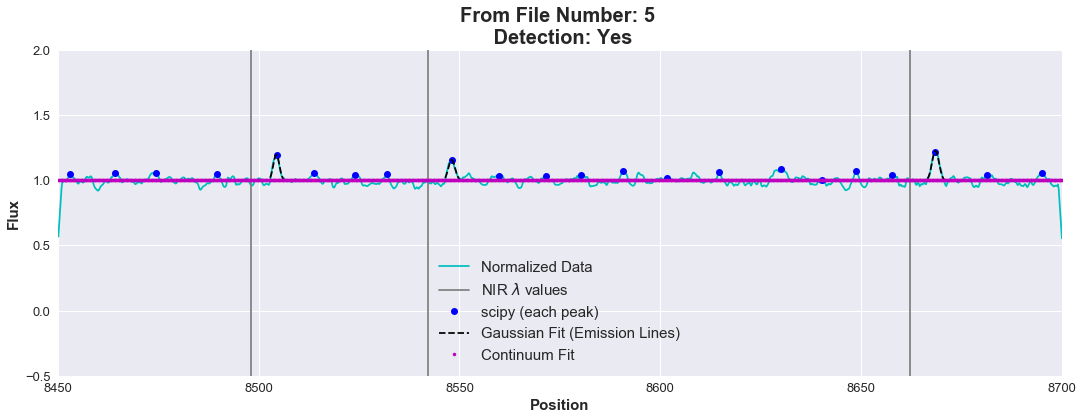

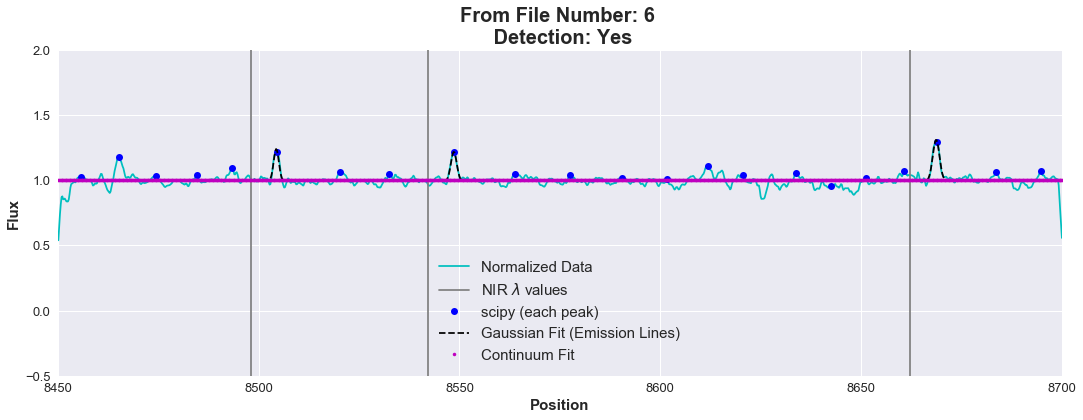

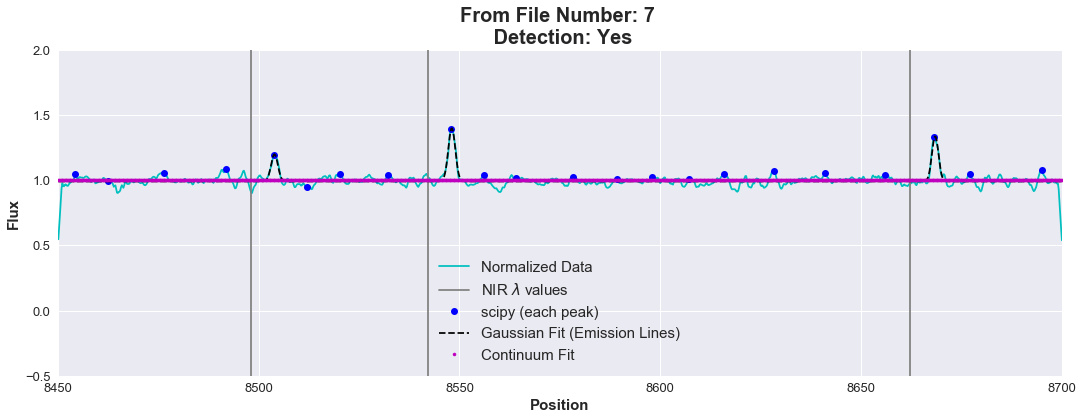

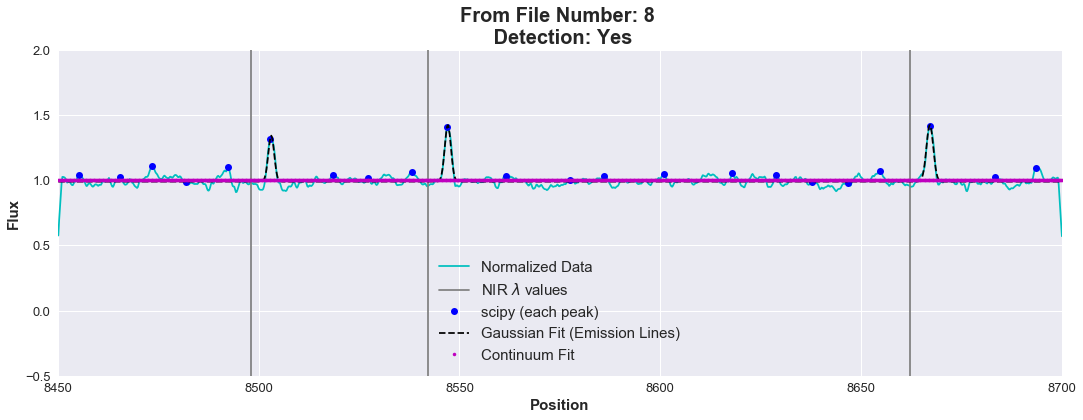

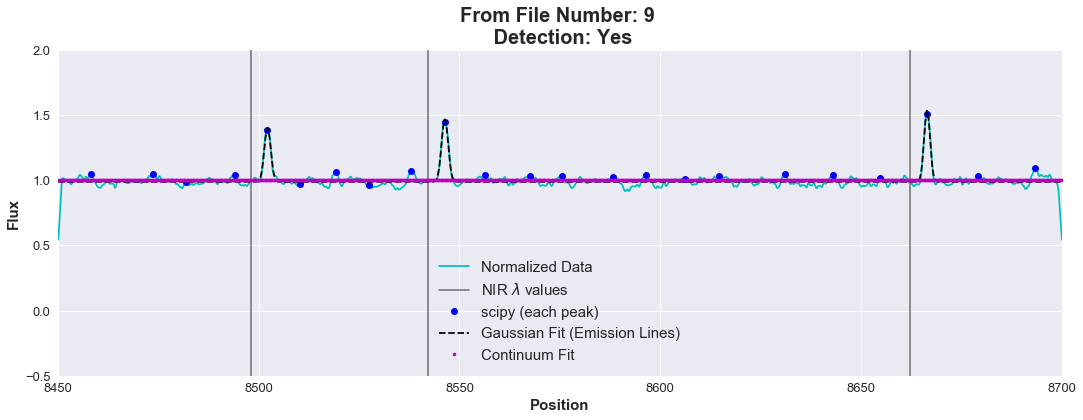

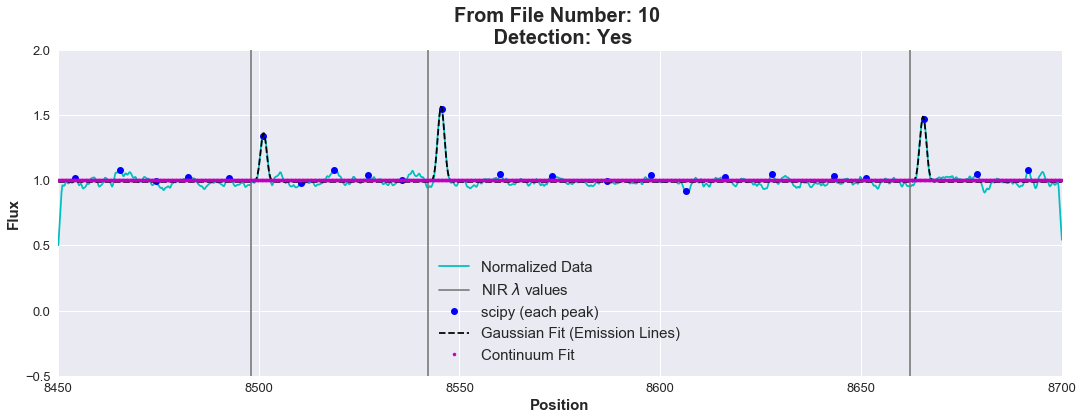

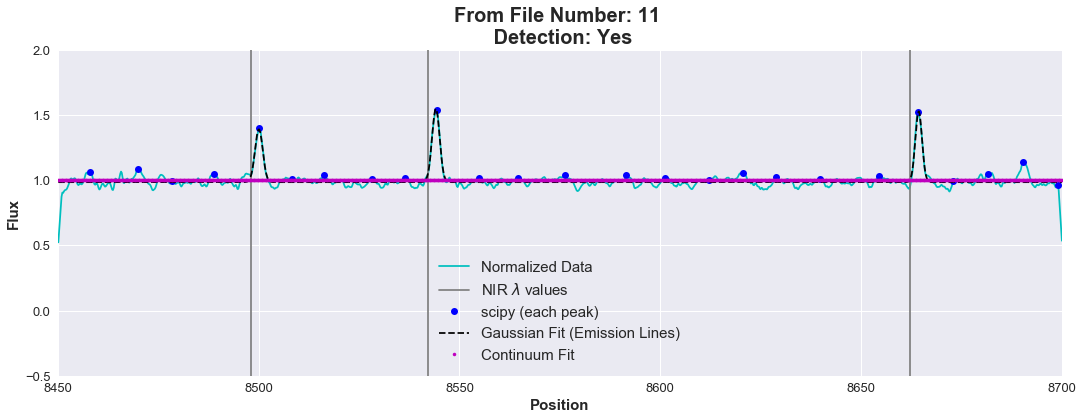

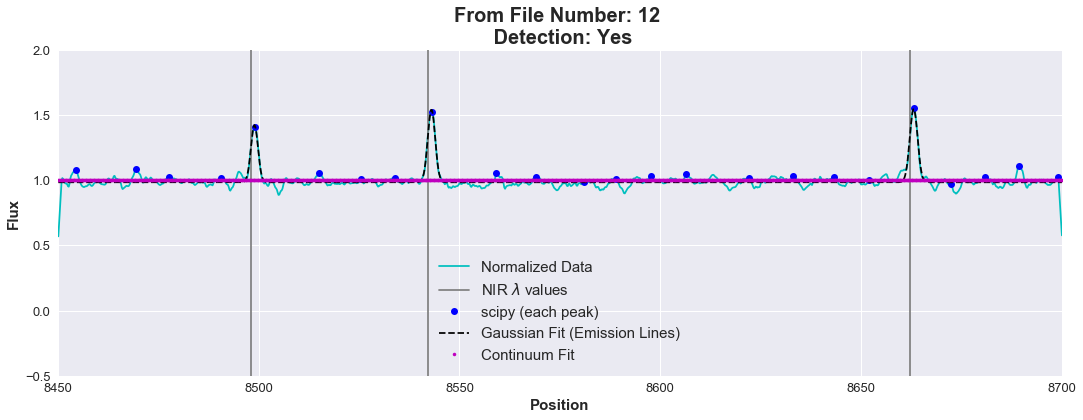

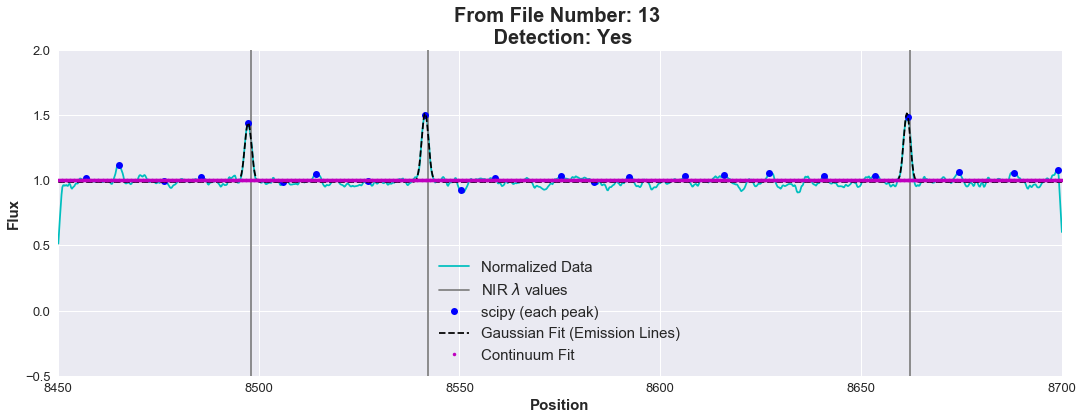

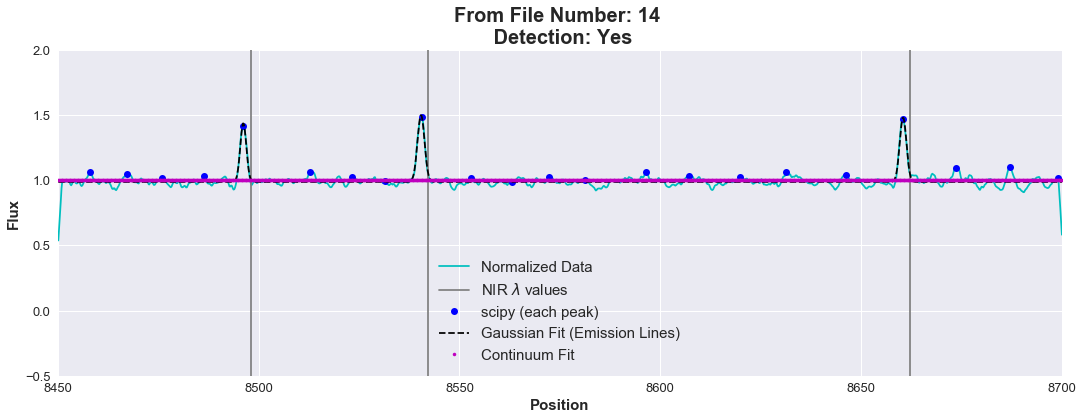

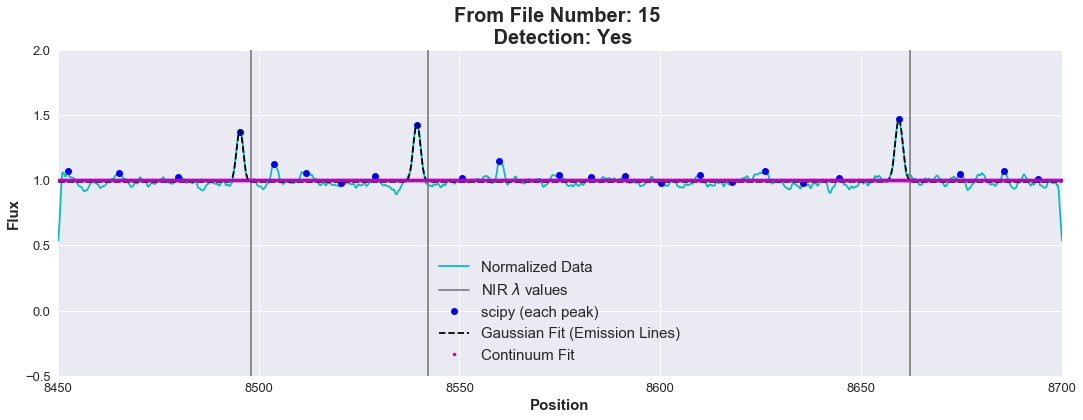

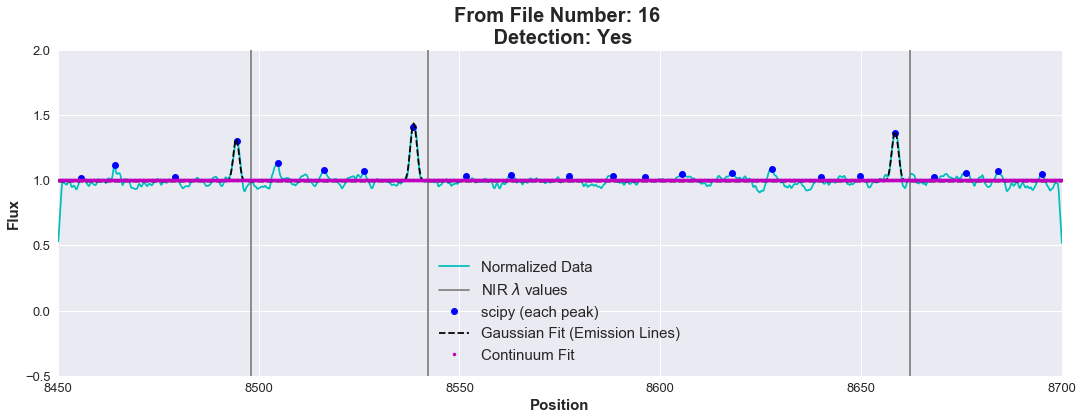

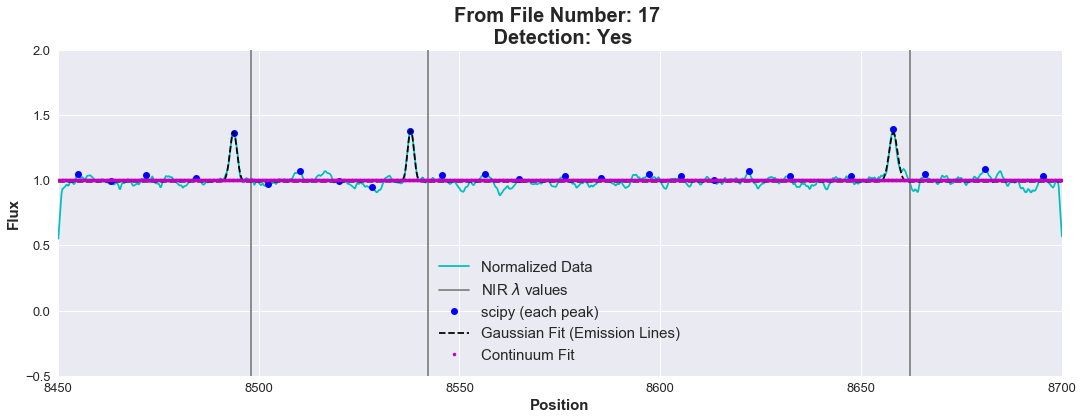

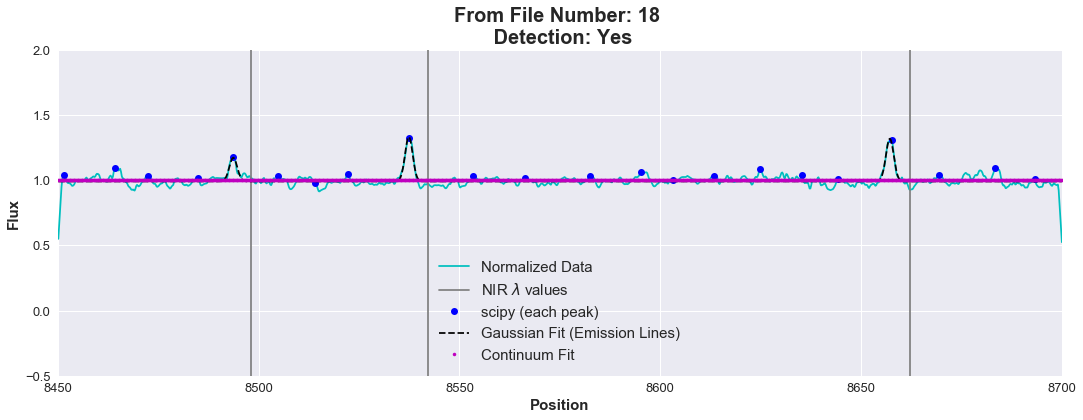

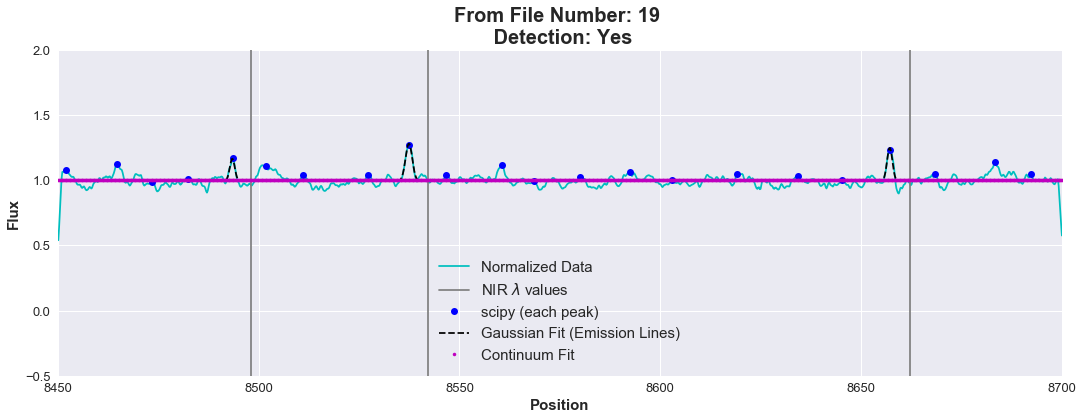

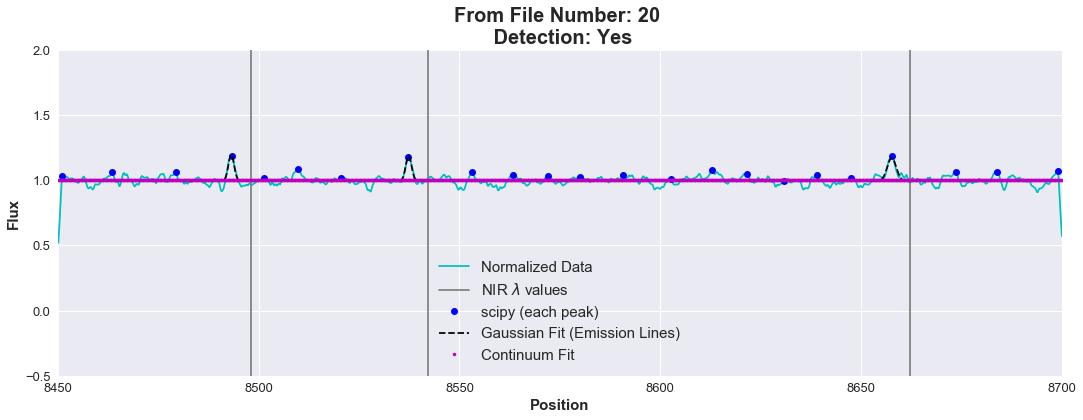

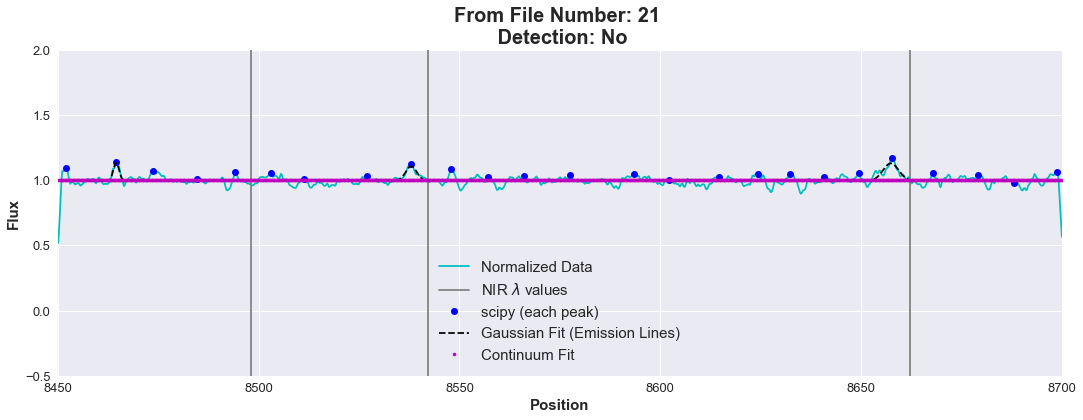

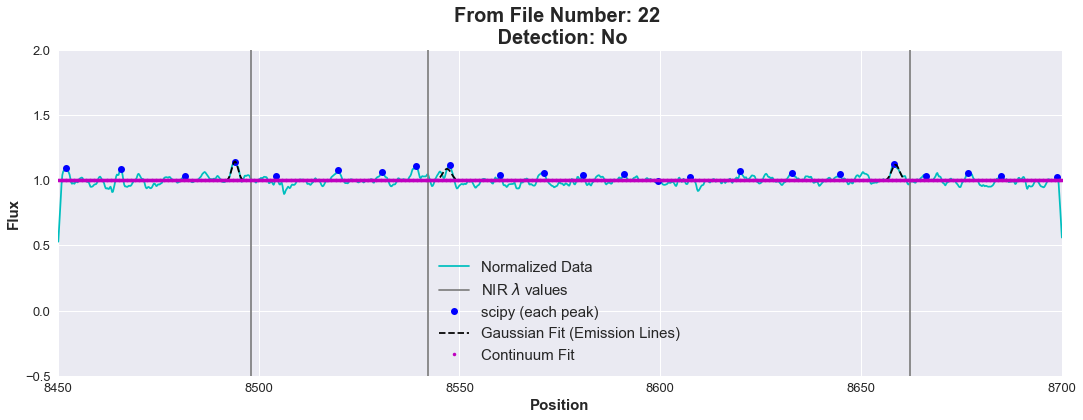

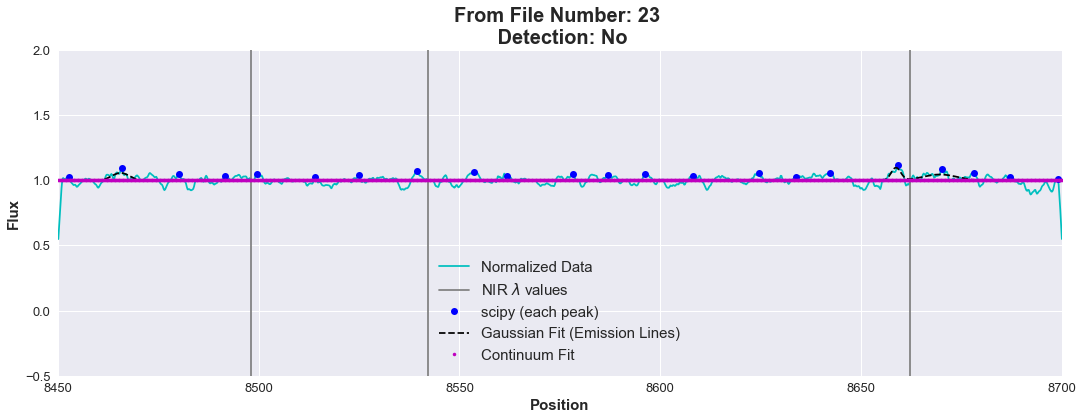

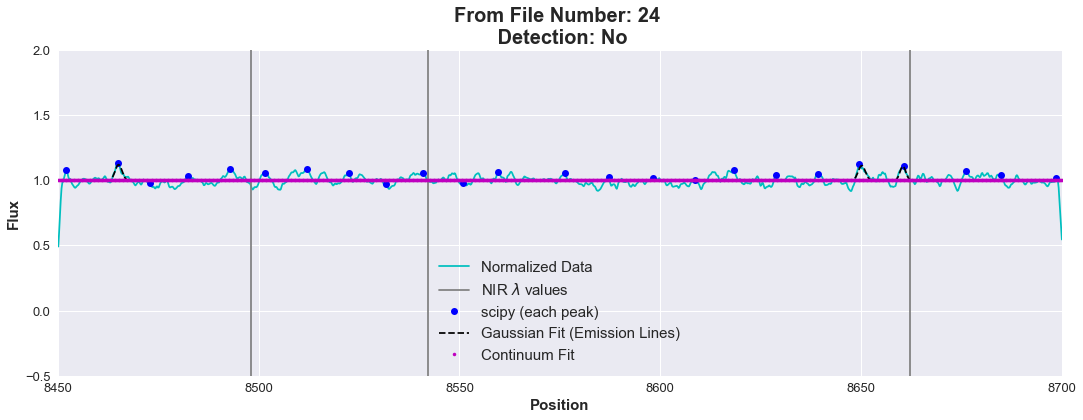

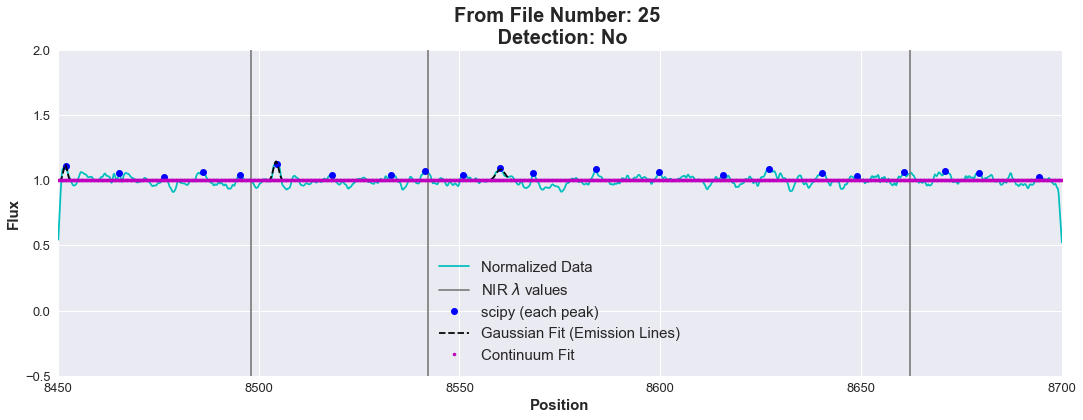

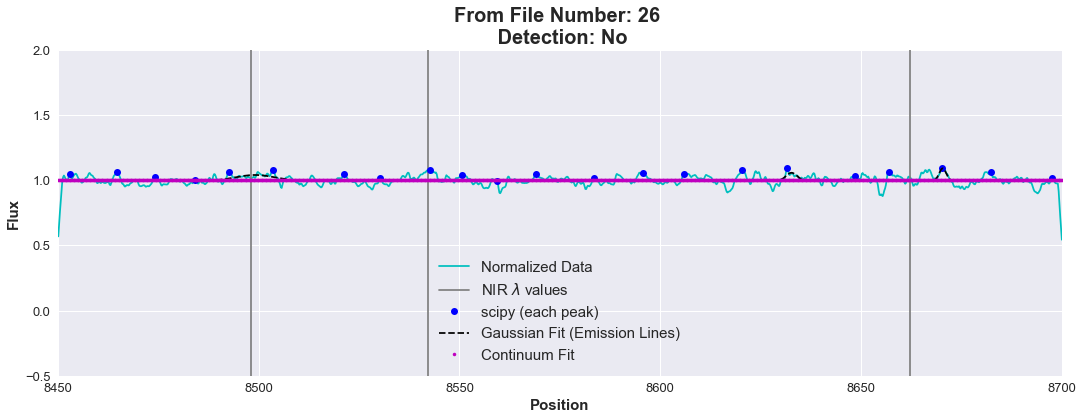

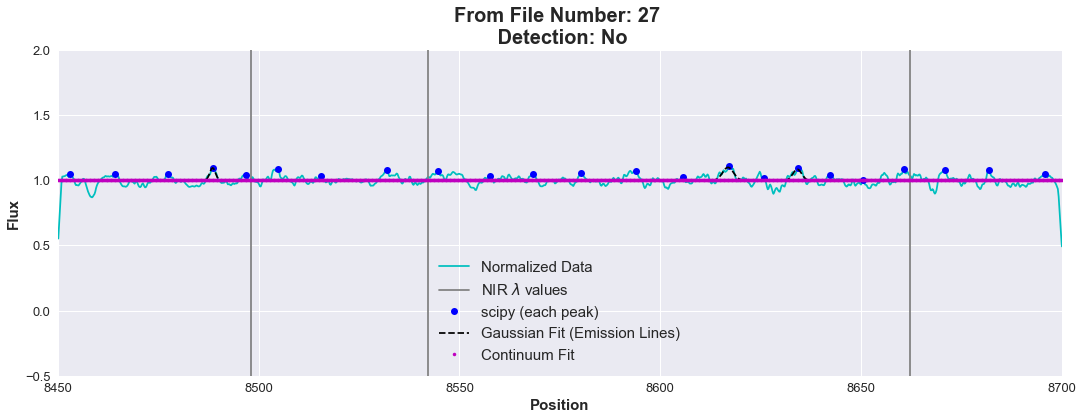

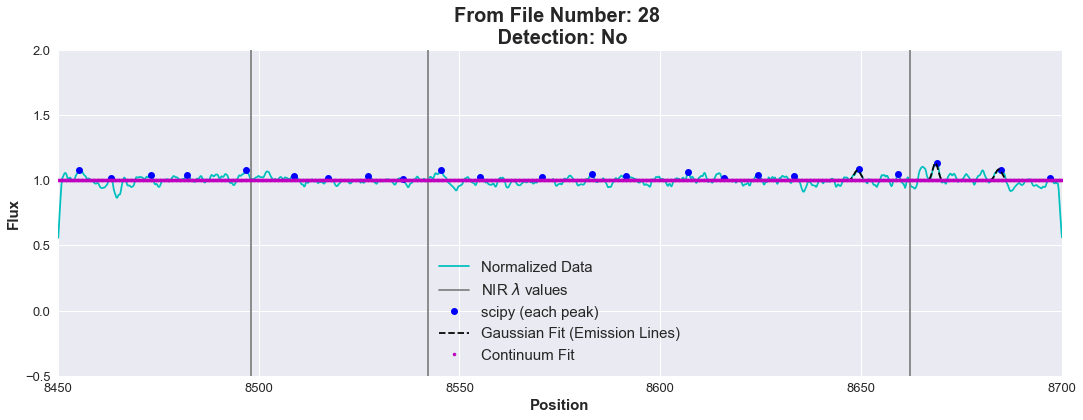

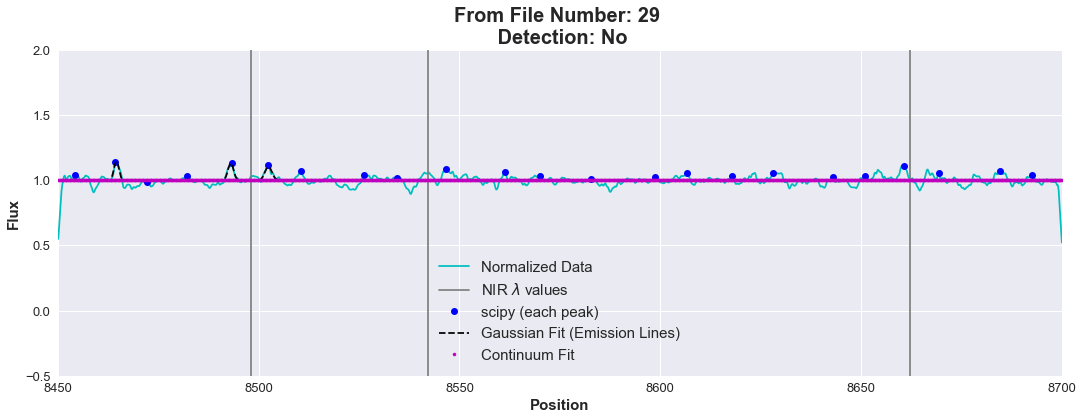

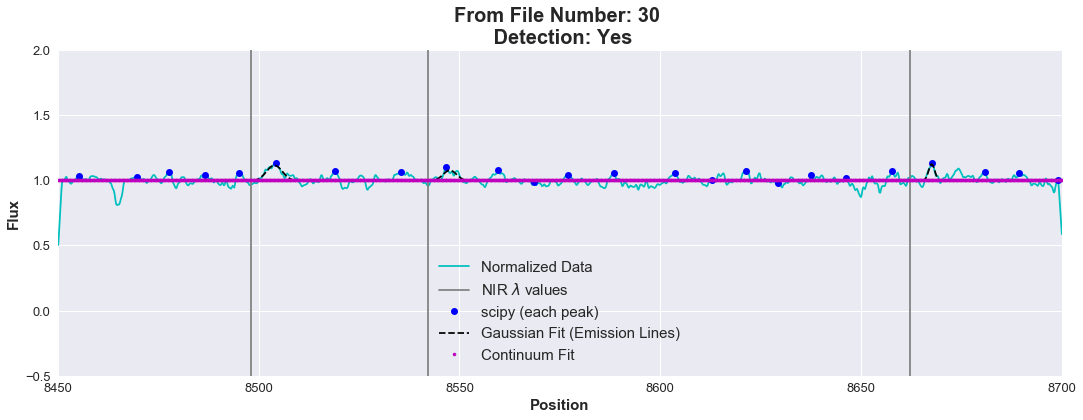

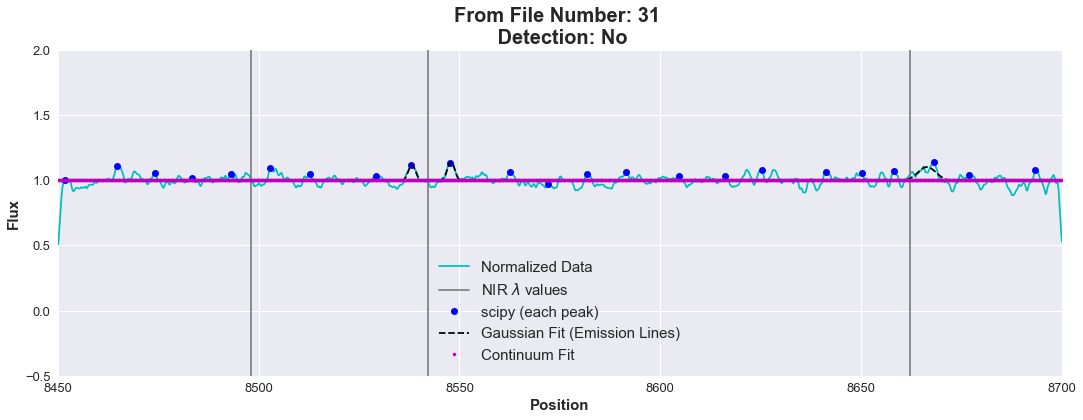

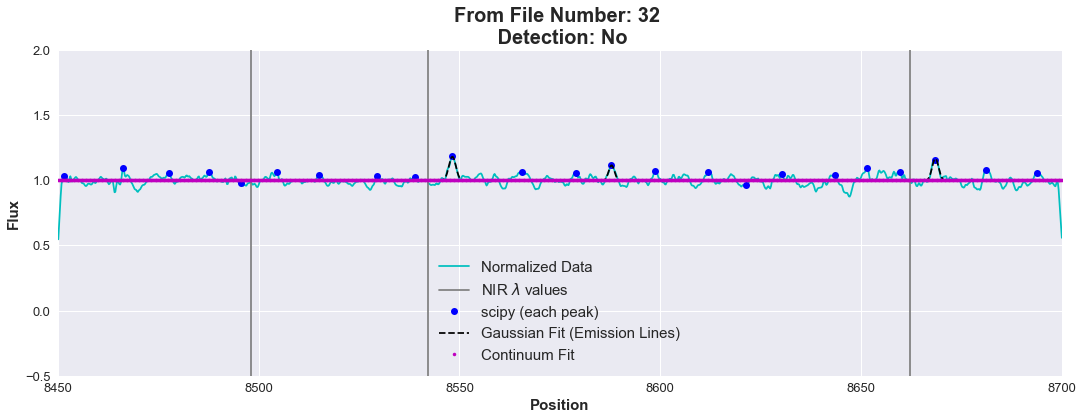

You can then look up where they should be from the NIST database (https://physics.nist.gov/PhysRefData/ASD/lines_form.html) and measure the doppler velocity for each spectrum.  

OG FIT VALUES: 0.04850527 0.01526921 0.01667328
FIT: [0.04627433 0.01426614 0.01426614]


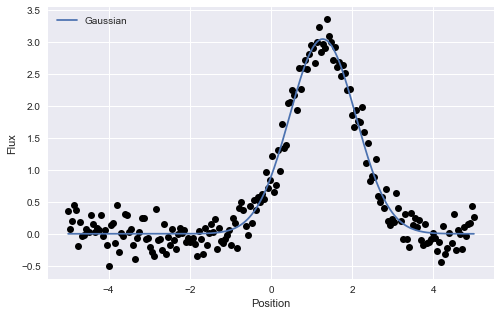

In [727]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

# Generate fake data
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)

mask = [x > 0]
# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=1, mean=0, stddev=1)
fitter = fitting.LevMarLSQFitter()
g = fitter(g_init,x,y)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('Position')
plt.ylabel('Flux')
plt.legend(loc=2)
print("OG FIT VALUES: 0.04850527 0.01526921 0.01667328")
print("FIT:",fit_e)

